<a href="https://colab.research.google.com/github/zw2497/Cycle_GAN_Tutorial/blob/master/cycle_gan_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -q install tensorflow-gpu==2.0.0-alpha0

# Import TensorFlow and other libraries

In [0]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

# Load and prepare the dataset

In [0]:
%%bash
mkdir datasets
FILE=apple2orange

if [[ $FILE != "ae_photos" && $FILE != "apple2orange" && $FILE != "summer2winter_yosemite" &&  $FILE != "horse2zebra" && $FILE != "monet2photo" && $FILE != "cezanne2photo" && $FILE != "ukiyoe2photo" && $FILE != "vangogh2photo" && $FILE != "maps" && $FILE != "cityscapes" && $FILE != "facades" && $FILE != "iphone2dslr_flower" && $FILE != "ae_photos" ]]; then
    echo "Available datasets are: apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos"
    exit 1
fi

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
wget -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

In [0]:
PATH = './datasets/apple2orange/'

In [0]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    return image/255.0

In [0]:
os.path.join(PATH, 'trainA/n07740461_10067.jpg')

In [0]:
inp = load(os.path.join(PATH, 'trainA/n07740461_10067.jpg'))
print(inp.shape)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp)

In [0]:
inpB = load(os.path.join(PATH, 'trainB/n07749192_10205.jpg'))
print(inpB.shape)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inpB)

# Model Building

# Generator

Refer to: https://www.tensorflow.org/alpha/tutorials/generative/pix2pix

In [0]:
def downsample(filters, size=4, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

test downsample


In [0]:
# 256,256,3 => 1,256,256,3 => 1,128,128,3 => 128, 128, 3
down_model = downsample(3)
down_result = down_model(tf.expand_dims(inp, 0))

plt.figure()
plt.imshow(down_result.numpy().reshape(128, 128, 3) * 10)
print(down_result.shape)

In [0]:
def upsample(filters, size=4, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

test upsample

In [0]:
up_model = upsample(3)
up_result = up_model(down_result)
print(up_result.shape)

plt.figure()
plt.imshow(down_result.numpy().reshape(128, 128, 3) * 10)

In [0]:
def Generator():
    g_filter = 64
    down_stack = [
        downsample(g_filter),
        downsample(g_filter * 2),
        downsample(g_filter * 4),
        downsample(g_filter * 8),
    ]

    up_stack = [
        upsample(g_filter * 4),
        upsample(g_filter * 2),
        upsample(g_filter),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
generator = Generator()

gen_output = generator(tf.expand_dims(inp, 0), training=False)
plt.imshow(gen_output[0,...] * 50)
print(gen_output.shape)

In [0]:
generator.summary()

# Discriminator

In [0]:
def Discriminator():
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    g_filter = 64
    
    down_stack = [
        downsample(g_filter),
        downsample(g_filter * 2),
        downsample(g_filter * 4),
        downsample(g_filter * 8),
    ]
    
    for down in down_stack:
        x = down(x)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same') # (bs, 30, 30, 1)
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
discriminator = Discriminator()
dis_output = discriminator(tf.expand_dims(inp, 0), training=False)
print(dis_output.shape)

## Start Training


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 256
BATCH_SIZE = 1

In [0]:
base_dir = '/content/datasets/apple2orange/'
BUFFER_SIZE = 32

trainA_dataset = tf.data.Dataset.list_files(PATH+'trainA/*.jpg')
trainA_dataset = trainA_dataset.shuffle(BUFFER_SIZE)
trainA_dataset = trainA_dataset.map(load)
trainA_dataset = trainA_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
trainB_dataset = tf.data.Dataset.list_files(PATH+'trainB/*.jpg')
trainB_dataset = trainB_dataset.shuffle(BUFFER_SIZE)
trainB_dataset = trainB_dataset.map(load)
trainB_dataset = trainB_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
for i in trainA_dataset:
    img_A = i
    print(i.shape)
    break
    
for i in trainB_dataset:
    img_B = i
    print(i.shape)
    break
    
plt.figure()
plt.imshow(img_A[0])
plt.figure()
plt.imshow(img_B[0])

In [0]:
EPOCHS = 200

In [0]:
opti = tf.keras.optimizers.Adam(0.0002, 0.5)

In [0]:
# Build and compile the discriminators
d_A = Discriminator()
d_B = Discriminator()
# d_A.compile(loss='mse',
#     optimizer=opti,
#     metrics=['accuracy'])
# d_B.compile(loss='mse',
#     optimizer=opti,
#     metrics=['accuracy'])

g_AB = Generator()
g_BA = Generator()

In [0]:
fake_B = g_AB(img_A, training=False)
fake_A = g_BA(img_B, training=False)

plt.figure()
plt.imshow(img_A[0])
plt.figure()
plt.imshow(fake_B[0])
plt.figure()
plt.imshow(img_B[0])
plt.figure()
plt.imshow(fake_A[0])

In [0]:
# def train_discriminator(imgs_A, imgs_B):   
#     valid = np.ones((BATCH_SIZE, 16, 16, 1)).astype('float32')
#     fake = np.zeros((BATCH_SIZE, 16, 16, 1)).astype('float32')
    
#     # Translate images to opposite domain
#     fake_B = g_AB(imgs_A, training=False)
#     fake_A = g_BA(imgs_B, training=False)
#     dB_loss_real = d_B.train_on_batch(imgs_B, valid)
#     dB_loss_fake = d_B.train_on_batch(fake_B, fake)
#     dB_loss = 0.5 * (np.array(dB_loss_real) + np.array(dB_loss_fake))

#     # Train the discriminators (original images = real / translated = Fake)
#     dA_loss_real = d_A.train_on_batch(imgs_A, valid)
#     dA_loss_fake = d_A.train_on_batch(fake_A, fake)
#     dA_loss = 0.5 * (np.array(dA_loss_real) + np.array(dA_loss_fake))



#     # Total disciminator loss
#     d_loss = dA_loss + dB_loss
#     return d_loss

In [0]:
@tf.function
def train_discriminator(imgs_A, imgs_B):   
    valid = np.ones((BATCH_SIZE, 16, 16, 1)).astype('float32')
    fake = np.zeros((BATCH_SIZE, 16, 16, 1)).astype('float32')
    
    with tf.GradientTape() as dB_tape:
        fake_B = g_AB(imgs_A, training=False)
        logits_real_B = d_B(imgs_B, training=True)
        logits_fake_B = d_B(fake_B, training=True)


        dB_loss_real = loss_function(logits_real_B, valid)
        dB_loss_fake = loss_function(logits_fake_B, fake)

        dB_loss = 0.5 * (np.array(dB_loss_real) + np.array(dB_loss_fake))
      
    with tf.GradientTape() as dA_tape:
        fake_A = g_BA(imgs_B, training=False)

        logits_real_A = d_A(imgs_A, training=True)
        logits_fake_A = d_A(fake_A, training=True)


        dA_loss_real = tf.keras.losses.mean_squared_error(logits_real_A, valid)
        dA_loss_fake = tf.keras.losses.mean_squared_error(logits_fake_A, fake)

        dA_loss = 0.5 * (np.array(dA_loss_real) + np.array(dA_loss_fake))
    
    gradients_of_dA = dA_tape.gradient(dA_loss, d_A.trainable_variables)
    gradients_of_dB = dB_tape.gradient(dB_loss, d_B.trainable_variables)
    opti.apply_gradients(zip(gradients_of_dA, d_A.trainable_variables))
    opti.apply_gradients(zip(gradients_of_dB, d_B.trainable_variables))


    # Total disciminator loss
#     d_loss = dA_loss + dB_loss
    return [tf.math.reduce_sum(dA_loss), tf.math.reduce_sum(dB_loss)]

In [0]:
@tf.function
def train_generator(imgs_A, imgs_B):
    with tf.GradientTape() as g:     
        valid = np.ones((BATCH_SIZE, 16, 16, 1)).astype('float32')
        fake = np.zeros((BATCH_SIZE, 16, 16, 1)).astype('float32')
        
        fake_B = g_AB(imgs_A, training=True)
        fake_A = g_BA(imgs_B, training=True)
        
        # Translate images back to original domain
        reconstr_A = g_BA(fake_B, training=True)
        reconstr_B = g_AB(fake_A, training=True)
        
        # Identity mapping of images
        img_A_id = g_BA(imgs_A, training=True)
        img_B_id = g_AB(imgs_B, training=True)

        valid_A = d_A(fake_A, training=False)
        valid_B = d_B(fake_B, training=False)

        gen_loss = [
            tf.math.reduce_mean(mean_squared_error(valid_A, valid)),
            tf.math.reduce_mean(mean_squared_error(valid_B, valid)),
            10 * tf.math.reduce_mean(mean_absolute_error(reconstr_A, imgs_A)),
            10 * tf.math.reduce_mean(mean_absolute_error(reconstr_B, imgs_B)),
            tf.math.reduce_mean(mean_absolute_error(img_A_id, imgs_A)),
            tf.math.reduce_mean(mean_absolute_error(img_A_id, imgs_B))
        ]

    gradients_of_generator = g.gradient(gen_loss, g_AB.trainable_variables + g_BA.trainable_variables)
    opti.apply_gradients(zip(gradients_of_generator, g_AB.trainable_variables + g_BA.trainable_variables))
    return gen_loss

In [0]:
def train(train_A_dataset, train_B_dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for batch_i, (imgs_A, imgs_B) in enumerate(zip(train_A_dataset, train_B_dataset)):
            d_loss = train_discriminator(imgs_A, imgs_B)
            g_loss = train_generator(imgs_A, imgs_B)
                
    print ('Time taken for epoch {} is {} sec\n'.format(epoch, time.time()-start))
    print("discriminator A: ", d_loss[0].numpy())
    print("discriminator B: ", d_loss[1].numpy())
    print("generator: {}\n".format([i.numpy() for i in g_loss]))
    plt.figure()
    gen_output = g_AB(tf.expand_dims(inp, 0), training=False)
    plt.imshow(gen_output[0,...])
    plt.show()
    plt.figure()
    gen_outputB = g_AB(tf.expand_dims(inpB, 0), training=False)
    plt.imshow(gen_outputB[0,...])
    plt.show()

In [0]:
train(trainA_dataset, trainB_dataset, EPOCHS)

W0506 04:09:35.485541 139847013050240 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0506 04:09:35.512525 139847013050240 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


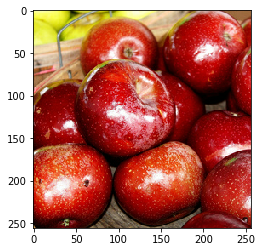

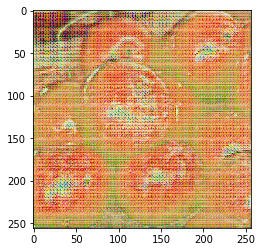

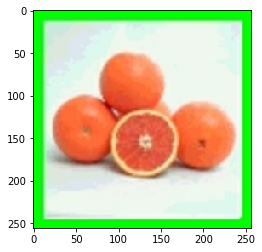

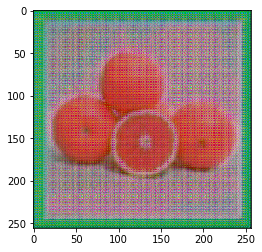

In [37]:
fake_B = g_AB(img_A, training=False)
fake_A = g_BA(img_B, training=False)

plt.figure()
plt.imshow(img_A[0])
plt.figure()
plt.imshow(fake_B[0])
plt.figure()
plt.imshow(img_B[0])
plt.figure()
plt.imshow(fake_A[0])